<a href="https://colab.research.google.com/github/omarhisham007/Deep-Learning/blob/main/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import library**

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt  

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from pathlib import Path

# **Load the Data**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Path to the dataset directory
CaptchaImages = r"/content/gdrive/MyDrive/Computer Vision/Dataset/CaptchaImages"
data_dir = Path( CaptchaImages )

In [6]:
# Get list of all the captcha images

Images = sorted( list(map(str, list(data_dir.glob('*.png')))) )
Labels = [ img.split(os.path.sep)[-1].split(".png")[0] for img in Images ]
Characters = set( char for label in Labels for char in label )
Image_Height = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in Images )
Image_Width = set( tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in Images )

# Maximum length of any captcha in the dataset
Max_Length = max([ len(label) for label in Labels ])

print( 'Number of images: ', len(Images) )
print( 'Number of labels: ', len(Labels), '\n' )
print( 'Width of any captcha image:', next(iter(Image_Width)) )
print( 'Height of any captcha image:', next(iter(Image_Height)) )
print( 'Characters present: ', Characters ) 
print( 'Number of characters: ', len(Characters) )
print( 'Maxium length of any captcha image: ', Max_Length )

Number of images:  1800
Number of labels:  1800 

Width of any captcha image: 104
Height of any captcha image: 24
Characters present:  {'7', '2', '1', '8', '5', '4', '9', '6', '0', '3'}
Number of characters:  10
Maxium length of any captcha image:  4


# **Hyper-parameters**

In [7]:
# Desired image dimensions
img_width = 104
img_height = 24


Epochs = 50

# Number of each batch
Batch_Size = 32

# Early Stopping

Early_Stopping_Patience = 10 
Min_Delta = 0.0001

# **Preprocessing**

In [8]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(Characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [14]:
def encode_single_sample( img_path, label ):
    img = tf.io.read_file( img_path )                         # 1. Read image
    img = tf.io.decode_png( img, channels=1 )                 # 2. Decode and convert to grayscale
    img = tf.image.convert_image_dtype( img, tf.float32 )     # 3. Convert to float32 in [0, 1] range
    img = tf.image.resize( img, [img_height,img_width] )      # 4. Resize to the desired size
    img = tf.transpose( img, perm=[1,0,2] )                   # 5. Transpose the image
    label = char_to_num( tf.strings.unicode_split(label, input_encoding='UTF-8') )      # 6. Map the characters in label to numbers
    return { "image": img, "label": label }                   # 7. Return

# **Training and Validation Sets**

In [15]:
# Splitting dataset
def split_data( Images, Labels, train_size=0.9, shuffle=True ):
    size = len( Images )              # 1. Get the total amount of the dataset
    indices = np.arange( size )       # 2. Indices array
    if shuffle:
        np.random.seed(42) 
        np.random.shuffle( indices )  
    train_samples = int( size*train_size )  # 3. The size of training samples

    # 4. Split data into training and validation sets
    x_train, y_train = Images[indices[:train_samples]], Labels[indices[:train_samples]]
    x_valid, y_valid = Images[indices[train_samples:]], Labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data( np.array(Images), np.array(Labels) )

print( 'Number of training set:', len(x_train) )
print( 'Number of validation set:', len(x_valid) )

Number of training set: 1620
Number of validation set: 180


In [16]:
# Create training and valodation dataset
train_dataset = tf.data.Dataset.from_tensor_slices( (x_train,y_train) )
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices( (x_valid,y_valid) )
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(Batch_Size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

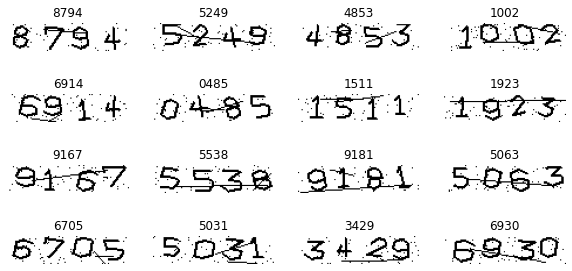

In [17]:
# Visualize the Training Dataset
_, ax = plt.subplots( 4, 4, figsize=(10,5) )
for batch in train_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for i in range(16):
        img = ( images[i]*255 ).numpy().astype('uint8')
        label = tf.strings.reduce_join( num_to_char(labels[i]) ).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow( img[:, :, 0].T, cmap='gray' )
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

# **Convolutional Recurrent Neural Network(CRNN)**

In [18]:
# Build an end point layer for implementing CTC loss.
class CTCLayer( layers.Layer ):
    def __init__( self, name=None, **kwargs ):
        super().__init__( name=name )
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value 
        batch_len = tf.cast( tf.shape(y_true)[0], dtype='int64' )
        input_length = tf.cast( tf.shape(y_pred)[1], dtype='int64' )
        label_length = tf.cast( tf.shape(y_true)[1], dtype='int64' )
        
        input_length = input_length*tf.ones( shape=(batch_len,1), dtype='int64' )
        label_length = label_length*tf.ones( shape=(batch_len,1), dtype='int64' )

        loss = self.loss_fn( y_true, y_pred, input_length, label_length )
        self.add_loss(loss)

        # return predictions
        return y_pred

In [19]:
def Build_Model():
    # Inputs to the model 
    input_tensor = Input( (img_width,img_height,1), dtype='float32', name='Input' )
    labels = Input( shape=(None,), dtype='float32', name="Label" )
    
    # First convolution
    x = Conv2D( 64, (3,3), activation='relu', padding='same', name='Conv_1' )(input_tensor)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_1' )(x)
    
    # Second convolution 
    x = Conv2D( 128, (3,3), activation='relu', padding='same', name='Conv_2' )(x)
    x = MaxPooling2D( pool_size=(2,2), strides=2, name='MaxPooling_2' )(x)
    
    # Third convolution
    x = Conv2D( 256, (3,3), activation='relu', padding='same', name='Conv_3' )(x)
    x = BatchNormalization( name='BN_1' )(x)
    
    # Fourth convolution block
    x = Conv2D( 512, (3,3), activation='relu', padding='same', name='Conv_4' )(x)  
    x = MaxPooling2D( pool_size=(2,1), strides=2, name='MaxPooling_3' )(x)
    
    # Fifth convolution block
    x = Conv2D( 512, (2,2), activation='relu', name='Conv_5' )(x)
    
    # Reshape accordingly
    Conv_Shape = x.get_shape( )
    x = Reshape( target_shape=(int(Conv_Shape[1]),int(Conv_Shape[2]*Conv_Shape[3])), name='Reshape' )(x)
    x = Dense( 64, activation='relu', name='Dense' )(x)
    x = Dropout( 0.25, name='Dropout' )(x)

    # RNNs
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_1' )(x)
    x = Bidirectional( LSTM( 256, return_sequences=True, dropout=0.25 ), name='LSTM_2' )(x)

    # Output layer
    x = Dense( len(Characters)+1, activation='softmax', name='Softmax' )(x) 

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer( name='CTC_Loss' )(labels, x)
    
    # Define the model
    model = Model( inputs=[input_tensor,labels], outputs=[output], name='CRNN_Model_with_CTC_LOSS' )    
    
    # Compile the model and return
    model.compile( optimizer=Adam() )
    
    return model

CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_Model_with_CTC_LOSS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 104, 24, 1)] 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 104, 24, 64)  640         Input[0][0]                      
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling2D)     (None, 52, 12, 64)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 52, 12, 128)  73856       MaxPooling_1[0][0]               
___________________________________________________________________________

# **Callbacks**

In [20]:
# Model Check Point
Check_Point = ModelCheckpoint( 'CRNN.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )

In [21]:
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )

In [22]:
History = CRNN.fit( train_dataset, validation_data=validation_dataset, epochs=Epochs, 
                    callbacks=[ Check_Point, Early_Stopping ] ) 

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 11.0452
Epoch 00001: val_loss improved from inf to 10.76098, saving model to CRNN.h5
51/51 [==============================] - 101s 2s/step - loss: 11.0452 - val_loss: 10.7610
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 10.6522
Epoch 00002: val_loss improved from 10.76098 to 10.67886, saving model to CRNN.h5
51/51 [==============================] - 87s 2s/step - loss: 10.6522 - val_loss: 10.6789
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 10.6353
Epoch 00003: val_loss did not improve from 10.67886
51/51 [==============================] - 92s 2s/step - loss: 10.6353 - val_loss: 10.7036
Epoch 4/50
51/51 [==============================] - ETA: 0s - loss: 9.1409
Epoch 00004: val_loss did not improve from 10.67886
51/51 [==============================] - 85s 2s/step - loss: 9.1409 - val_loss: 17.4514
Epoch 5/50
51/51 [==============================] - ETA: 0s - loss: 3.2453
Epo

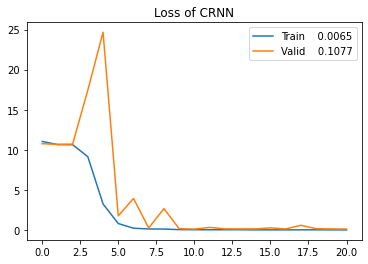

In [25]:
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.subplot( )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train'+"{:10.4f}".format( min(History.history['loss']) ) )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Valid'+"{:10.4f}".format( min(History.history['val_loss']) ) )
plt.legend( loc='upper right' )
plt.title( 'Loss of CRNN')
plt.show()

In [26]:
# Get the prediction
prediction_model = Model( CRNN.get_layer( name='Input' ).input, CRNN.get_layer( name='Softmax' ).output, name='Prediction' )
prediction_model.summary()

Model: "Prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 104, 24, 1)]      0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 104, 24, 64)       640       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 52, 12, 64)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 52, 12, 128)       73856     
_________________________________________________________________
MaxPooling_2 (MaxPooling2D)  (None, 26, 6, 128)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 26, 6, 256)        295168    
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 26, 6, 256)        1

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


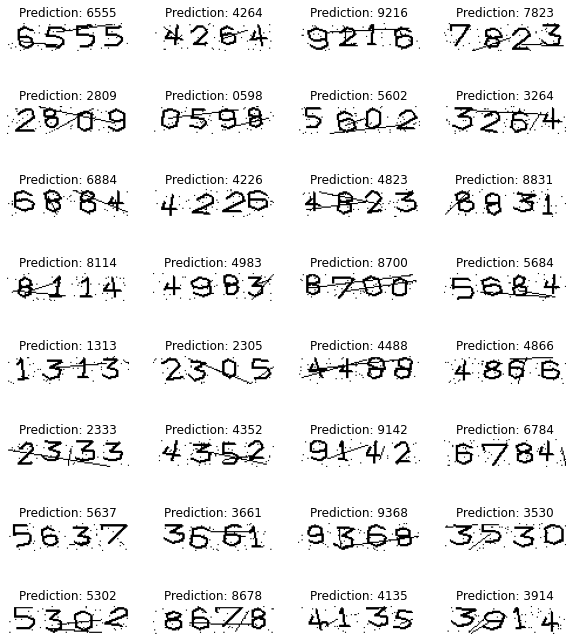

In [27]:
# Function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:Max_Length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

#  Check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        orig_texts.append(label)

    _, ax = plt.subplots( 8, 4, figsize=(10,12) )
    for i in range(len(pred_texts)):
        img = ( batch_images[i, :, :, 0]*255).numpy().astype(np.uint8)
        img = img.T
        title = f'Prediction: {pred_texts[i]}'
        ax[i // 4, i % 4].imshow( img, cmap='gray' )
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()